In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from nice.algorithms.connectivity_AT import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d

In [ ]:
file_numbers = [1,2, 3, 4]

structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))

    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]

    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left
    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]

    left_attleft = data['SP'][0][0][left_indices_agg, 100:350, :]  #left input spikes
    right_attleft = data['SP'][0][1][left_indices_agg, 100:350, :]
    att_attleft = data['SP'][0][2][left_indices_agg, 100:350]

    left_attright = data['SP'][0][0][right_indices_agg, 100:350, :]  #right input spikes
    right_attright = data['SP'][0][1][right_indices_agg, 100:350, :]
    att_attright = data['SP'][0][2][right_indices_agg, 100:350]  

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright
##e.g. dataset 1 gives left_attleft of shape (469 trials, 500 time points, 160 spikes)
    

def collect_data(file_numbers):
    l_al, l_ar, r_al, r_ar, a_al, a_ar = [], [], [], [], [], []
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar
   

In [52]:
def smooth_data(data, sigma=1):
    return gaussian_filter1d(data, sigma=sigma, axis=1)  #Gaussian filter along the time axis

def normalize_inputs(x_train, x_test, x_val):   #note that this will take the mean and stc based on the training data only
    z_train = np.zeros_like(x_train)
    z_test = np.zeros_like(x_test)
    z_val = np.zeros_like(x_val)

    x_train = smooth_data(x_train, sigma=1)
    x_test = smooth_data(x_test, sigma=1)
    x_val = smooth_data(x_val, sigma=1)

    mean = np.mean(x_train, axis=0)  #(1, time, neurons)
    std = np.std(x_train, axis=0)

    #avoids divide-by-zero
    std[std < 1e-6] = 1.0

    z_train = (x_train - mean) / std
    z_test  = (x_test - mean) / std
    z_val   = (x_val - mean) / std

    if np.isnan(z_train).any():
        raise ValueError("Data contains NaN values after normalization.")

    return (
        torch.tensor(z_train, dtype=torch.float32),
        torch.tensor(z_test, dtype=torch.float32),
        torch.tensor(z_val, dtype=torch.float32)
    )


def normalize_targets(y_train, y_test, y_val):
    print('shape of y_train',y_train.shape)

    mean = np.mean(y_train, axis = 0)  #shape (1, num_neurons)
    std = np.std(y_train, axis=0)
   
    if np.isscalar(std):  # Check if std is a scalar
        std = np.array([std])  # Convert to array for consistency
    if np.isscalar(mean):  # Check if mean is a scalar
        mean = np.array([mean])  # Convert to array for consistency

    std[std < 1e-6] = 1.0

    y_train_norm = (y_train - mean) / std
    y_test_norm  = (y_test - mean) / std
    y_val_norm   = (y_val - mean) / std

    return (
        torch.tensor(y_train_norm, dtype=torch.float32),
        torch.tensor(y_test_norm, dtype=torch.float32),
        torch.tensor(y_val_norm, dtype=torch.float32),
        mean, std
    )


In [ ]:
def prep_data(x_list, y_list, batch_size=16, shuffle=True):
    #concatenating all of the datasets
    x_raw = np.concatenate(x_list, axis=0)   # (N, T, neurons)
    y_raw = np.concatenate(y_list, axis=0)   # (N, T, 1) or (N, T)
    print('shape of inputs:',  x_raw.shape)
    print('shape of outputs:', y_raw.shape)

    #finding the output counts
    y_counts = np.sum(y_raw[:, :, 0], axis=1) 
    print('number of firings:', y_counts.shape)

    #ttv split
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(
        x_raw, y_counts, test_size=0.2, random_state=42, shuffle=shuffle
    )
    X_val, X_te, y_val, y_te = train_test_split(
        X_tmp, y_tmp, test_size=0.5, random_state=42, shuffle=shuffle
    )

    #then norm based on training data
    X_tr, X_te, X_val     = normalize_inputs(X_tr, X_te, X_val)
    y_tr, y_te, y_val, mu, sigma = normalize_targets(y_tr, y_te, y_val)

    #wrap as tensors
    def make_ds(X, y):
        #x might already be a torch.Tensor (from normalize_inputs)
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X).float()
        else:
            X = X.float()
        if isinstance(y, np.ndarray):
            y = torch.from_numpy(y).float().unsqueeze(-1)
        else:
            y = y.float().unsqueeze(-1)
        return TensorDataset(X, y)

    train_ds = make_ds(X_tr, y_tr)
    val_ds   = make_ds(X_val, y_val)
    test_ds  = make_ds(X_te,  y_te)

    #build dataloaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

    return train_loader, val_loader, test_loader, mu, sigma


In [54]:
class SpikingAttentionLSTM(nn.Module):
    def __init__(self, input_dim = 160, hidden_dim = 128, output_dim = 1, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim, 
            batch_first = True,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0.0,  #dropout only applies if num_layers > 1

        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)  #dropout layer

    def forward(self, x):
        out_seq, (h_n, c_n) = self.lstm(x)
        h_last = h_n[-1]
        h_drop = self.dropout(h_last)
        out = self.fc(h_drop)
        return out.view(-1, 1)
    


#making a simple feedforward neural network to test the data
class SpikingAttentionNN(nn.Module):
    def __init__(self, input_dim = 160, output_dim = 80, hidden_dim = 128, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    

In [55]:
def train(model, train_loader, val_loader,
           criterion, epochs=1000, clip_value = 1.0, 
           lr = 1e-3, wd = 1e-5, patience = 20):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_history = []
    validation_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  #gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
           for xb_val, yb_val in val_loader:
                val_loss += criterion(model(xb_val), yb_val).item()
        val_loss_item = val_loss / len(val_loader)
        validation_loss_history.append(val_loss_item)

        #early stopping
        if val_loss_item < best_val_loss:
            best_val_loss = val_loss_item
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break

        if epoch % 4 == 0:
            clear_output(wait=True)  #clears the Jupyter output cell
            plt.figure(figsize=(10, 7))
            plt.plot(loss_history, label = 'Training Loss')
            plt.plot(validation_loss_history, label = 'Validation Loss')
            plt.legend()
            plt.xlim(0, epochs)
            plt.ylim(0, 1)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Losses')
            plt.grid(True)
            plt.show()


    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, validation_loss_history


In [74]:
l_al, _, r_al, _, a_al, _ = collect_data(file_numbers)
#so this will just look at the 0th neuron from the attention layer

#each gets n_datafiles here and have to index them later

print('shape of left_attleft',l_al[0].shape)  #this is just the shape for the first file
print('shape of right_attleft',r_al[0].shape)
print('shape of attention layer left',a_al[0].shape)

shape of left_attleft (468, 250, 160)
shape of right_attleft (468, 250, 160)
shape of attention layer left (468, 250, 80)


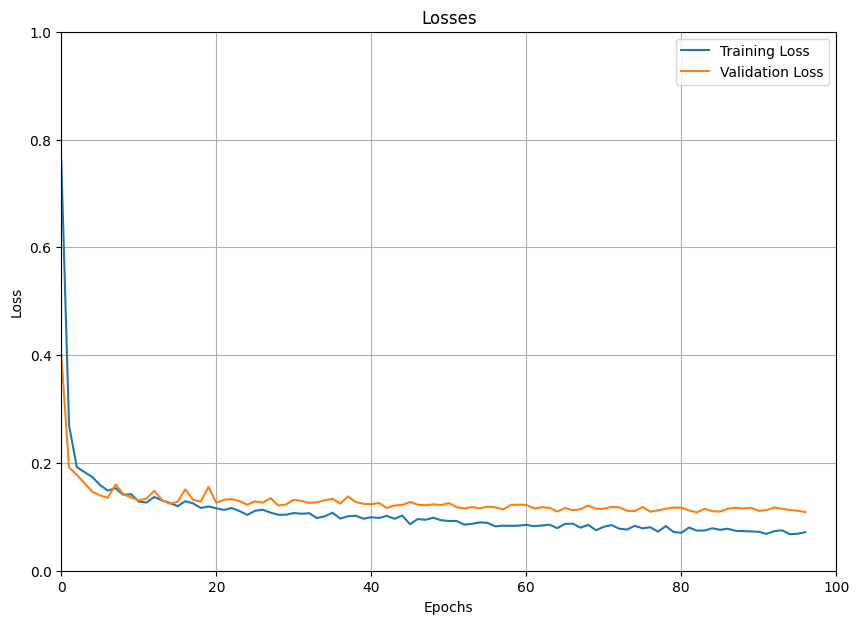

Early stopping at epoch 97 with validation loss: 0.1082
Test MSE: 0.0941
y_pred shape: (187, 1)
y_true shape: (187, 1)


In [75]:
# ─── Prepare the data ─────────────────────────────────────────────────────
train_loader_left, val_loader_left, test_loader_left, mean_left, std_left = prep_data(
    l_al, a_al,
    batch_size=32,
    shuffle=True
)

# ─── Inspect input dim ────────────────────────────────────────────────────
# grab one batch from the train loader to get (batch, time, neurons)
sample_x, _ = next(iter(train_loader_left))
n_neurons_in = sample_x.shape[2]
print('n_neurons:', n_neurons_in)

# ─── Instantiate your model ───────────────────────────────────────────────
model_left = SpikingAttentionLSTM(
    input_dim=n_neurons_in,
    hidden_dim=32,
    output_dim=1,   # predicting one spike‐count per trial
    num_layers=1,
    dropout=0.5
)

# ─── Train ────────────────────────────────────────────────────────────────
criterion = nn.MSELoss()
loss_history_left, validation_loss_history_left = train(
    model_left,
    train_loader_left,
    val_loader_left,   # now passing the val_loader
    criterion,
    epochs=100,
    lr=1e-3,
    wd=1e-4,
    patience=15
)

# ─── Final evaluation on test set ────────────────────────────────────────
model_left.eval()
test_mse = 0.0
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in test_loader_left:
        preds = model_left(xb)
        test_mse += criterion(preds, yb).item()
        all_preds.append(preds.cpu().numpy())
        all_trues.append(yb.cpu().numpy())

test_mse /= len(test_loader_left)
print(f"Test MSE: {test_mse:.4f}")

# ─── (Optional) flatten predictions & truths into arrays ─────────────────
y_pred_trained_l = np.concatenate(all_preds, axis=0)  # shape (n_test, 1)
y_true_test     = np.concatenate(all_trues, axis=0)  # same shape
print('y_pred shape:', y_pred_trained_l.shape)
print('y_true shape:', y_true_test.shape)


In [76]:
y_pred_values_left = y_pred_trained_l * std_left + mean_left
y_true_values_left = y_true_test * std_left + mean_left

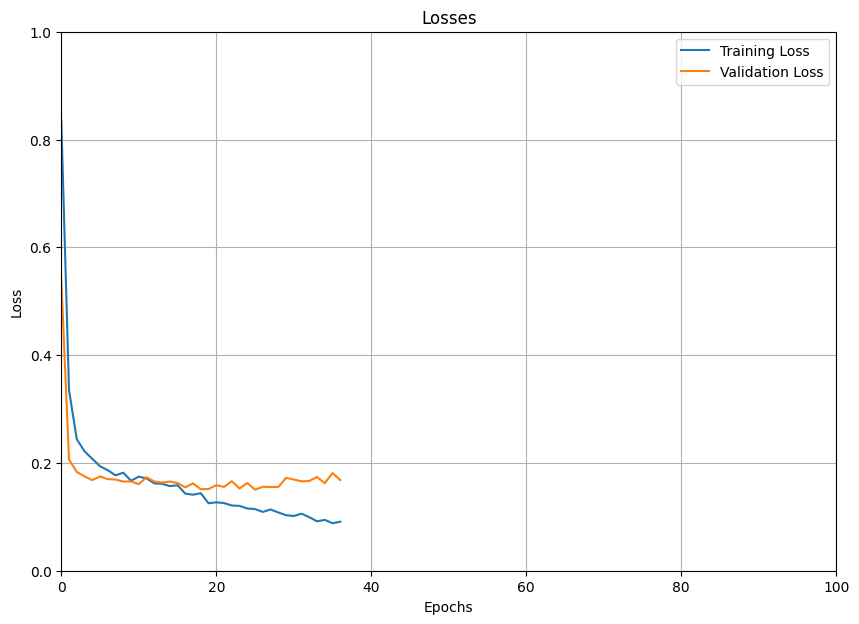

Early stopping at epoch 40 with validation loss: 0.1504
Right‐set Test MSE: 0.1711
y_pred_right shape: (187, 1)
y_true_right shape: (187, 1)


In [77]:
# ─── Prepare the right‐condition data ─────────────────────────────────────
train_loader_right, val_loader_right, test_loader_right, mean_r, std_r = prep_data(
    r_al, a_al,
    batch_size=32,
    shuffle=True
)

# ─── Inspect input dim for right model ────────────────────────────────────
sample_x_r, _ = next(iter(train_loader_right))
n_neurons_in_r = sample_x_r.shape[2]
print('n_neurons (right):', n_neurons_in_r)

# ─── Instantiate the right‐model ──────────────────────────────────────────
model_right = SpikingAttentionLSTM(
    input_dim=n_neurons_in_r,
    hidden_dim=32,
    output_dim=1,   # still predicting one spike‐count per trial
    num_layers=1,
    dropout=0.5
)

# ─── Train the right‐model ─────────────────────────────────────────────────
criterion = nn.MSELoss()
loss_history_right, validation_loss_history_right = train(
    model_right,
    train_loader_right,
    val_loader_right,
    criterion,
    epochs=100,
    lr=1e-3,
    wd=1e-4,
    patience=15
)

# ─── Final evaluation on right test set ───────────────────────────────────
model_right.eval()
test_mse_right = 0.0
all_preds_r, all_trues_r = [], []

with torch.no_grad():
    for xb, yb in test_loader_right:
        preds_r = model_right(xb)
        test_mse_right += nn.MSELoss()(preds_r, yb).item()
        all_preds_r.append(preds_r.cpu().numpy())
        all_trues_r.append(yb.cpu().numpy())

test_mse_right /= len(test_loader_right)
print(f"Right‐set Test MSE: {test_mse_right:.4f}")

# ─── (Optional) flatten right predictions & truths ─────────────────────────
y_pred_trained_r = np.concatenate(all_preds_r, axis=0)  # shape (n_test, 1)
y_true_test_r    = np.concatenate(all_trues_r, axis=0)  # same shape
print('y_pred_right shape:', y_pred_trained_r.shape)
print('y_true_right shape:',  y_true_test_r.shape)


In [78]:
y_pred_values_right = y_pred_trained_r * std_r + mean_r
y_true_values_right = y_true_test_r * std_r + mean_r

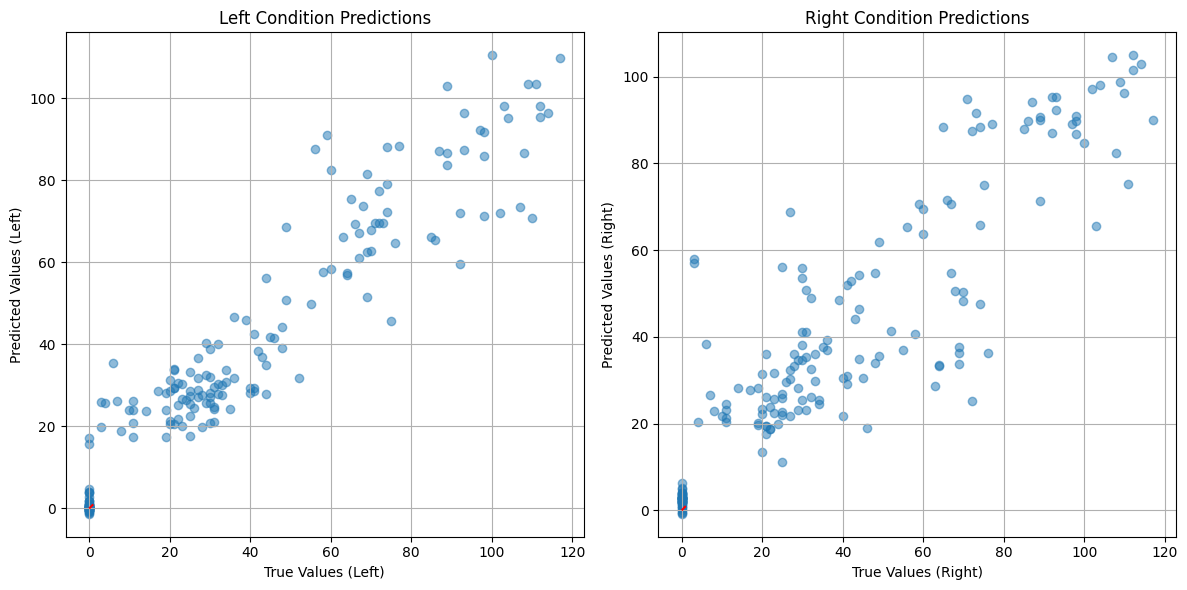

Left MSE: 116.88195926938658
Right MSE: 210.6537730721939
Left R2: 0.8994105726425982
Right R2: 0.8187098972633498


In [93]:
#plotting scatter of left results, pred and true, above right results, pred and true
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_true_values_left, y_pred_values_left, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('True Values (Left)')
plt.ylabel('Predicted Values (Left)')
plt.title('Left Condition Predictions')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.scatter(y_true_values_right, y_pred_values_right, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # diagonal line
plt.xlabel('True Values (Right)')
plt.ylabel('Predicted Values (Right)')
plt.title('Right Condition Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()

#printing r2 and mse for left and right
mse_left = mean_squared_error(y_true_values_left, y_pred_values_left)
mse_right = mean_squared_error(y_true_values_right, y_pred_values_right)
r2_left = r2_score(y_true_values_left, y_pred_values_left)
r2_right = r2_score(y_true_values_right, y_pred_values_right)

print('Left MSE:', mse_left)
print('Right MSE:', mse_right)
print('Left R2:', r2_left)
print('Right R2:', r2_right)



In [ ]:
def plot_predictions_vs_ground_truth(model_left, x_data_left, y_data_left, model_right, x_data_right, y_data_right, num_examples=5, width = 16):
    """
    model     : your trained model
    x_data    : (n_trials, time, input_dim) or subset for val/test set
    y_data    : (n_trials, output_dim) ground truth
    num_examples : how many random trials to plot
    """
    model_left.eval()
    with torch.no_grad():
        y_pred_left = model_left(x_data_left)  #(n_trials, 80)
    

    y_pred_left_np = y_pred_left.detach().cpu().numpy()
    y_data_left_np = y_data_left.detach().cpu().numpy() if isinstance(y_data_left, torch.Tensor) else y_data_left

    n_trials = y_pred_left_np.shape[0]

    model_right.eval()
    with torch.no_grad():
        y_pred_right = model_right(x_data_right)

    y_pred_right_np = y_pred_right.detach().cpu().numpy()
    y_data_right_np = y_data_right.detach().cpu().numpy() if isinstance(y_data_right, torch.Tensor) else y_data_right
    
    #randomly choose some trials to visualize
    trials_to_plot = np.random.choice(n_trials, size=num_examples, replace=False)


    fig, ax = plt.subplots(2, num_examples, figsize=(width, 7))
    
    if num_examples == 1:
        ax = np.array(ax).reshape(2, 1)
        
    for i, trial_idx in enumerate(trials_to_plot):
        ax[0, i].plot(y_data_left_np[trial_idx], 'ko-', label='Ground Truth')
        ax[0, i].plot(y_pred_left_np[trial_idx], 'ro-', label='Prediction')
        ax[0, i].set_title(f'Left Model - Trial {trial_idx}')
        ax[0, i].set_xlabel('Neuron Index')
        ax[0, i].set_ylabel('Firing Rate')
        ax[0, i].legend()
        ax[0, i].grid(True)

        ax[1, i].plot(y_data_right_np[trial_idx], 'ko-', label='Ground Truth')
        ax[1, i].plot(y_pred_right_np[trial_idx], 'ro-', label='Prediction')
        ax[1, i].set_title(f'Right Model - Trial {trial_idx}')
        ax[1, i].set_xlabel('Neuron Index')
        ax[1, i].set_ylabel('Firing Rate')
        ax[1, i].legend()
        ax[1, i].grid(True)

    plt.tight_layout()
    plt.show()


  